# HV scan with Trigger on Cosmic Rays

In questo script vengono analizzati i dati ottenuti triggerando sulle coincidenze


APERTURA di: ../../../Data/PMTgem/verticale/verticaleNewEd1500_470.root
6509
...(470) Caricamento Dati...
...Caricamento Dati Completato!...


...(470) Organizzazione Dati...
...Organizzazione Completata...


...Controllo Eventi Da Scartare...
...Eventi Scartati da ../../../Data/PMTgem/verticale/verticaleNewEd1500_470.root: 29/6509


...(470) Rimozione Piedistallo...
...Piedistallo Rimosso...


...(470) Calcolo del Segnale in Corrente e Rimozione degli Eventi Da Scartare...
...Calcolo & Rimozione Completati...


...CONTROLLO -> Eventi Eliminati da ../../../Data/PMTgem/verticale/verticaleNewEd1500_470.root 28


...(470) Calcolo dell'Integrale di Carica...


file dati Segnale e Totale creati...


...Calcolo Eseguito...




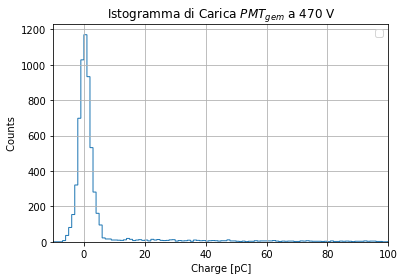

...(470) Calcolo del Valore Medio e Salvataggio...
---- Analisi su ../../../Data/PMTgem/verticale/verticaleNewEd1500_470.root COMPLETATA! ----


----- ANALISI GENERALE CONCLUSA!!!! ------


In [16]:
import ROOT as root
import numpy as np
import matplotlib.pyplot as plt

from ROOT import TMath , TF1, TH1F
import scipy.stats as st 

#--------IMPOSTAZIONI OBBLIGATORIE------------------
voltage = [470]
#[380 , 400 , 420 , 450 , 480 , 490]# 2gem New
#[380 , 400 , 420 , 450 , 470 , 480 , 490]# 2gem
#[380 , 400 , 420] # 3gem
#
#[400 , 420 ,450 , 470 , 490]# 1gem
#[380 , 400 , 420 , 440 , 450]# 3gem New
#


nGEM = '2'
cc = "" #"Old" o ""
folderName = "" #"" o "new"

#-----------------------------------------------
#--------ATTENZIONE:------------------------------ 
#se si analizzano i dati nel folder "3GEMnew" è necessario cambiare l'intervallo di integrazione
#
#se "new" -> [600:800] quindi dati in 3GEMnew
#se "" -> [500:700] quindi dati in altre cartelle
#
#in quanto cambia il drift e quindi le waveform si spostano
#-------------------------------------------------
#-------------------------------------------------


#--------INIZIO PROGRAMMA--------------
#definisco degli array in cui salvare dinamicamente i valori da graficare
means = []
errors = []
hv = []

dataset1 = []
dataset1Blu = []
dataset1Verde = []

dataset2 = []
dataset2Blu = []
dataset2Verde = []

dataset3 = []
dataset3Blu = []
dataset3Verde = []


pied1 = []
pied2 = []
pied3 = []

for number in voltage: #ciclo che permette di aprire tutti i file in sequenza
    filename = '../../../Data/PMTgem/verticale/verticaleNewEd1500_470.root'
    #'../../../Data/PMTgem/'+nGEM+'GEM'+ folderName +'/Cosmici'+nGEM+'G_%s.root'%(str(number)) 
    #
    #
    #_%s_1000eventi.root'%(str(number)) 
    #
    #
    #filename = 'scanED2000.root'
    print("\nAPERTURA di: " + filename)
    
    fileROOT = root.TFile(filename)#"chargeDataBlu.root") #nome del rootfile
    tree = fileROOT.Get("t1") #nome del datatree

    n = 1024
    nCh = 4
    nDat = n*nCh #numero dati per evento...vengono salvati in riga tutti i canali
    nEvts = tree.GetEntries() #numero di eventi
    
    wave = np.zeros((nEvts,nDat))
    time = np.zeros((nEvts,nDat))
    
    print(nEvts)
    print('...(%d) Caricamento Dati...'%(number))
    i=0
    for dat in tree:
        wave[i] = np.array(dat.wave_array)
        time[i] = np.array(dat.time_array)
        i = i+1    

    print('...Caricamento Dati Completato!...\n\n')

    waveCh1 = np.zeros((nEvts,n))
    waveCh2 = np.zeros((nEvts,n))
    waveCh3 = np.zeros((nEvts,n))
    waveCh4 = np.zeros((nEvts,n))

    timeCh1 = np.zeros((nEvts,n))
    timeCh2 = np.zeros((nEvts,n))
    timeCh3 = np.zeros((nEvts,n))
    timeCh4 = np.zeros((nEvts,n))
    
    print('...(%d) Organizzazione Dati...'%(number))
    
    for i in range(nEvts):
        for j in range(nDat):
            if j < nDat/4:
                waveCh1[i][j] = wave[i][j]
                timeCh1[i][j] = time[i][j]
            elif j >= nDat/4 and j < nDat/2:
                waveCh2[i][j-n] = wave[i][j]
                timeCh2[i][j-n] = time[i][j]
            elif j >= nDat/2 and j < nDat*3/4:
                waveCh3[i][j-2*n] = wave[i][j]
                timeCh3[i][j-2*n] = time[i][j]
            elif j >= nDat*3/4: 
                waveCh4[i][j-3*n] = wave[i][j]
                timeCh4[i][j-3*n] = time[i][j]

    print('...Organizzazione Completata...\n\n')
    j = 0
    print('...Controllo Eventi Da Scartare...')
    for i in range(nEvts):
        if min(waveCh4[i]) < -110 and waveCh4[i].argmin() < 5: 
            #print(i , waveCh4[i].argmin() , timeCh4[i][waveCh4[i].argmin()])
            j = j+1
    print('...Eventi Scartati da ' + filename + ': ' + str(j) + '/' + str(nEvts) + '\n\n')
    
    print('...(%d) Rimozione Piedistallo...'%(number))

    for i in range(nEvts):
        waveCh4[i] = waveCh4[i]-np.mean(waveCh4[i][5:55])
    print("...Piedistallo Rimosso...\n\n")
    
    print('...(%d) Calcolo del Segnale in Corrente e Rimozione degli Eventi Da Scartare...'%(number))
   
    waveCh4A = [] #PMT GEM
    waveCh2A = [] #Scintillatore BLU
    waveCh3A = [] #Scintillatore VERDE
  
    R = 50 #resistenza in Ohm   
    signal = []
    
    for i in np.arange(1,nEvts):
        #butto gli eventi con il picco strano
        if (min(waveCh4[i]) >= -110 or ( min(waveCh4[i])< -110  and waveCh4[i].argmin() != 1 )):
            waveCh4A.append(waveCh4[i]/R) #conversione dati Tensione -> dati Corrente
            waveCh2A.append(waveCh2[i]/R) #blu
            waveCh3A.append(waveCh3[i]/R) #verde
            if min(waveCh4[i]) <= -20:
                signal.append(waveCh4[i]/R)
        else: 1 
            #print(min(waveCh4[i]) , waveCh4[i].argmin() , i) #check

    #Riconverto le liste delle forme d'onda di corrente in array
    #waveCh4A = np.array(waveCh4A)
    #waveCh2A = np.array(waveCh2A)
    #waveCh3A = np.array(waveCh3A)
    #signal = np.array(signal)
    
    #print(waveCh4A.shape)
    print('...Calcolo & Rimozione Completati...\n\n')
            
    print('...CONTROLLO -> Eventi Eliminati da ' + filename + ' ' + str(nEvts - len(waveCh4A)) + '\n\n')#check
    
    print('...(%d) Calcolo dell\'Integrale di Carica...'%(number))
    #integral = np.zeros(len(waveCh4A))

    integral = []
    integralB = []
    integralV = []
    integralS = []
    
    #Eseguo l'Integrale

#    file = open("histoCarica3_"+str(number)+".dat", "w")


#---------------------------------------------------------------------
#---------------------------INTEGRAZIONE------------------------------
#---------------------------------------------------------------------

    for i in range(len(waveCh4A)):
        #treshold = max(waveCh4A[i][100:200]) - min(waveCh4A[i][100:200])
        #treshold = np.std(waveCh4A[i][100:200])
        #print(treshold)
        #for j in range(len(waveCh4A[i][400:650])):
         #   if waveCh4A[i][j] <= -3*treshold:
        integral.append(sum(-waveCh4A[i][100:300]))#[500:700]))  #<------Modificare qui l'intervallo di integrazione!
        integralB.append(sum(-waveCh2A[i][100:800]))
        integralV.append(sum(-waveCh3A[i][100:800]))
        #        break
        
  
       
    #integral = np.array(integral)
    #integralB = np.array(integralB)
    #integralV = np.array(integralV)
    
    file = open( "histoCaricaVerticale"+cc+nGEM+"G_%s.dat"%(str(number)) , "w" )
    for i in range(len(integral)):
        file.write(str(integral[i])+"\t" + str(integralB[i]) + "\t" +str(integralV[i]) + "\n")
    file.close()
     
    
#--------INTEGRAZIONE DEL SOLO SEGNALE------------
    for i in range(len(signal)):
        integralS.append(sum(-signal[i][100:300]))#[500:700])) #<-------Modificare qui l'intervallo di integrazione!

    file = open("histoCaricaVerticale"+cc+nGEM+"G_S"+str(number)+".dat", "w")
    for i in range(len(integralS)):
        file.write(str(integralS[i]) + "\n")
    file.close()
    
    print("\n\nfile dati Segnale e Totale creati...\n\n")
    
    
    
    
    
    
    
    #if number == 480:#102:
    #    for data in integral:
    #        dataset1.append(data)
    #    for data in integralB:
    #        dataset1Blu.append(data)
    #    for data in integralV:
    #        dataset1Verde.append(data)
    #        
    #    for p in integralP:
    #        pied1.append(p)
    #
    #elif number == 490:
    #    for data in integral:
    #        dataset2.append(data)
    #    for data in integralV:
    #        dataset2Verde.append(data)
    #    for data in integralB:
    #        dataset2Blu.append(data)
    #    
    #    for p in integralP:
    #        pied2.append(p)
    #    
    #elif number == 470:
    #    for data in integral:
    #        dataset3.append(data)
    #    for data in integralV:
    #        dataset3Verde.append(data)
    #    for data in integralB:
    #        dataset3Blu.append(data)
    #    
    #    for p in integralP:
    #        pied3.append(p)
    print('...Calcolo Eseguito...\n\n')

    
    #----ISTOGRAMMA----

    xmin = min(integral)
   
    h1 = TH1F( "h1", "Istogramma di Carica $PMT_{gem}$ a %d V ; Charge [pC] ; Counts "%(number), 3050, -50, 3000 )
    for i in integral:
        h1.Fill(i)
       
    xmax = h1.GetBinCenter(h1.GetMaximumBin())#max(integral)#  #è la x del max dell'istogramma
    
    from rootplot import root2matplotlib as r2m
    
    histo1 = r2m.Hist(h1) #permette di leggere l'istogramma già riempito da root
    histo1.hist(histtype = 'step' , fill = False) #fa l'istogramma
    plt.grid()
    plt.legend()
    histo1.show_titles()
    plt.xlim((-10 , 100))
    #plt.savefig('histo'+ str(number) + '.png')
    plt.show()

    #----------------------------
    
    print('...(%d) Calcolo del Valore Medio e Salvataggio...'%(number))
    
    #print(np.mean(integral) , func.GetParameter(1))

    #means.append(np.mean(integral))#func.GetParameter(1))#
    #errors.append(func.GetParameter(2)/np.sqrt(len(integral)))#func.GetParError(1))#
    #hv.append(number)
    
    
    
    
    
#fine analisi
    print('---- Analisi su ' + filename + ' COMPLETATA! ----\n\n')
    
print('----- ANALISI GENERALE CONCLUSA!!!! ------')

In [ ]:
#plt.errorbar(np.array(hv) , np.array(means) , yerr = np.array(errors) , fmt = "*" , capsize = 5 , elinewidth = 1)
plt.scatter(np.arange(len(integral)) , integral , s = 2)
#plt.plot(np.arange(len(integral)))
plt.grid()
plt.xlabel('$n Event$')
plt.ylabel('Charge Integral [pC]')
plt.title('Charge Integral  in time')
#plt.savefig('CaricaVsHVCosmici.png')
plt.show()
print(len(integral))

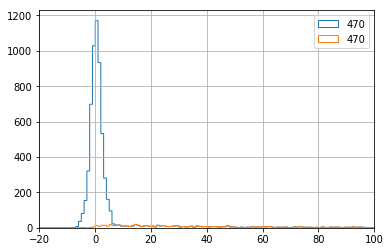

In [17]:
maxBin = 3000.
minBin = -50.
nBin = 3050.
binw = (maxBin-minBin)/nBin

plt.hist(np.array(integral) , histtype = 'step' , fill = False , label = '470' , bins = np.arange(minBin , maxBin+binw , binw))
plt.hist(np.array(integralS) , histtype = 'step' , fill = False , label = '470' , bins = np.arange(minBin , maxBin+binw , binw))

#plt.hist(np.array(pied1) , histtype = 'step' , fill = False , label = 'piedistallo480', bins = np.arange(minBin , maxBin+binw , binw))

#plt.hist(np.array(dataset2) , histtype = 'step' , fill = False , label = '490' , bins = np.arange(minBin , maxBin+binw , binw))
#plt.hist(np.array(pied2) , histtype = 'step' , fill = False , label = 'piedistallo490' , bins = np.arange(minBin , maxBin+binw , binw))

#plt.hist(np.array(dataset3) , histtype = 'step' , fill = False , label = '470' , bins = np.arange(minBin , maxBin+binw , binw))
#plt.hist(np.array(pied3) , histtype = 'step' , fill = False , label = 'piedistallo470' , bins = np.arange(minBin , maxBin+binw , binw))


#plt.yscale("log")
plt.xlim((-20, 100))
plt.legend()
plt.grid()
#plt.savefig('piedistallo480.png')
plt.show()
